In [2]:
# TORCH implementation of load_data
import os
import numpy as np
import pickle

import seaborn as sns
from collections import Counter
import random

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms



import matplotlib.pyplot as plt

In [3]:
from scr.pytorch_model_defs import WaterPlasticModel

In [4]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [5]:
# Define the transformations for MNIST
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
batch_size_train = 64
batch_size_test = 1

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    batch_size=batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform),
    batch_size=batch_size_test, shuffle=True
)

print("Data Loaders are ready!")

Data Loaders are ready!


In [6]:
for images, labels in train_loader:
    print(images.shape)
    break

torch.Size([64, 1, 32, 32])


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
class WaterPlasticModel(nn.Module):
    def __init__(self, num_classes=2, in_channels=12):
        super(WaterPlasticModel, self).__init__()
        
        # Conv2D(16, 12, padding='same') -> kernel_size=12, padding=6 for same-like effect
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=12, padding=6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv2D(32, 12, padding='same')
        self.conv2 = nn.Conv2d(16, 32, kernel_size=12, padding=6)
        
        # Conv2D(64, 12, padding='same')
        self.conv3 = nn.Conv2d(32, 64, kernel_size=12, padding=6)
        
        # We'll dynamically determine in_features for the first dense layer
        self.fc1 = None
        self.fc2 = nn.Linear(128, num_classes)
    
    def _initialize_fc1(self, x):
        """Dynamically initializes the first fully connected layer based on the flattened conv output."""
        in_features = x.view(x.size(0), -1).shape[1]
        self.fc1 = nn.Linear(in_features, 128).to(x.device)
    
    def forward(self, x):
        # Convolution + ReLU + Pool layers
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        # Flatten
        if self.fc1 is None:
            self._initialize_fc1(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [9]:
# Model for MNIST data set 10 classes 1 channel
model = WaterPlasticModel(num_classes=10, in_channels=1)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print('Running model')
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)        # Forward
        loss = criterion(outputs, labels)  
        loss.backward()               # Backprop
        optimizer.step()              # Update weights
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Running model
Epoch [1/10], Loss: 0.1507
Epoch [2/10], Loss: 0.0474
Epoch [3/10], Loss: 0.0340
Epoch [4/10], Loss: 0.0261
Epoch [5/10], Loss: 0.0206
Epoch [6/10], Loss: 0.0189
Epoch [7/10], Loss: 0.0171
Epoch [8/10], Loss: 0.0138
Epoch [9/10], Loss: 0.0119
Epoch [10/10], Loss: 0.0103


In [10]:
torch.save(model, "10_epochs_mnistdata.pth")

In [53]:
model = torch.load('10_epochs_mnistdata.pth', weights_only=False)


In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

def confusion_matrix_plot(model, validation_loader, device='cpu'):
    # Ensure model is in evaluation mode
    model.eval()

    y_true = []
    y_pred = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for inputs, labels in validation_loader:
            # Move data to the specified device (CPU or GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Get predictions
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1)

            # Collect labels and predictions
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


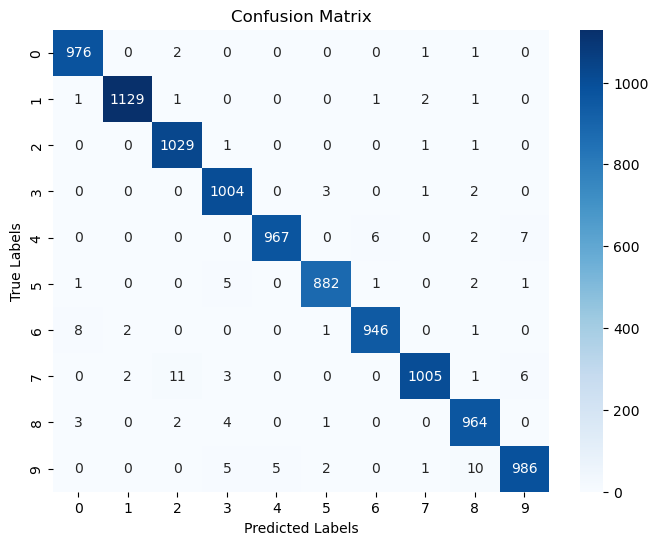

In [55]:
# Evaluate and plot
confusion_matrix_plot(model, test_loader)


### Grad CAM

In [56]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt


In [57]:
for images, labels in test_loader:
    input_tensor = images
    break

In [58]:
digit_image = input_tensor.squeeze().numpy() 
min_value = digit_image.min()
max_value = digit_image.max()

digit_image_normalized = (digit_image - min_value) / (max_value - min_value)


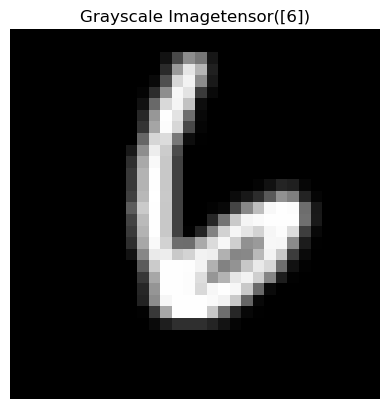

In [59]:

# Plot the grayscale image
plt.imshow(digit_image_normalized, cmap="gray")
plt.title(f"Grayscale Image{labels}")
plt.axis("off")  # Optional: Turn off axes
plt.show()

In [78]:
#target_layers = [model.conv3]
#target_layers = [model.conv1]
target_layers = [model.conv2]

cam = GradCAM(model=model, target_layers=target_layers)

In [79]:
print(f"Current Label: {labels[0]}")

target_label = labels[0]

Current Label: 6


In [80]:
targets = [ClassifierOutputTarget(1)]

In [81]:
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

In [82]:
model_outputs = cam.outputs

In [83]:
model_outputs

tensor([[ -6.7419,  -7.3435, -15.8701, -20.5546, -11.2576,  -5.4781,  29.6183,
         -19.9912, -11.4998, -29.7352]], grad_fn=<AddmmBackward0>)

In [84]:
grayscale_cam.shape

(1, 32, 32)

In [85]:
print(grayscale_cam.shape)
print(digit_image_normalized.shape)

(1, 32, 32)
(32, 32)


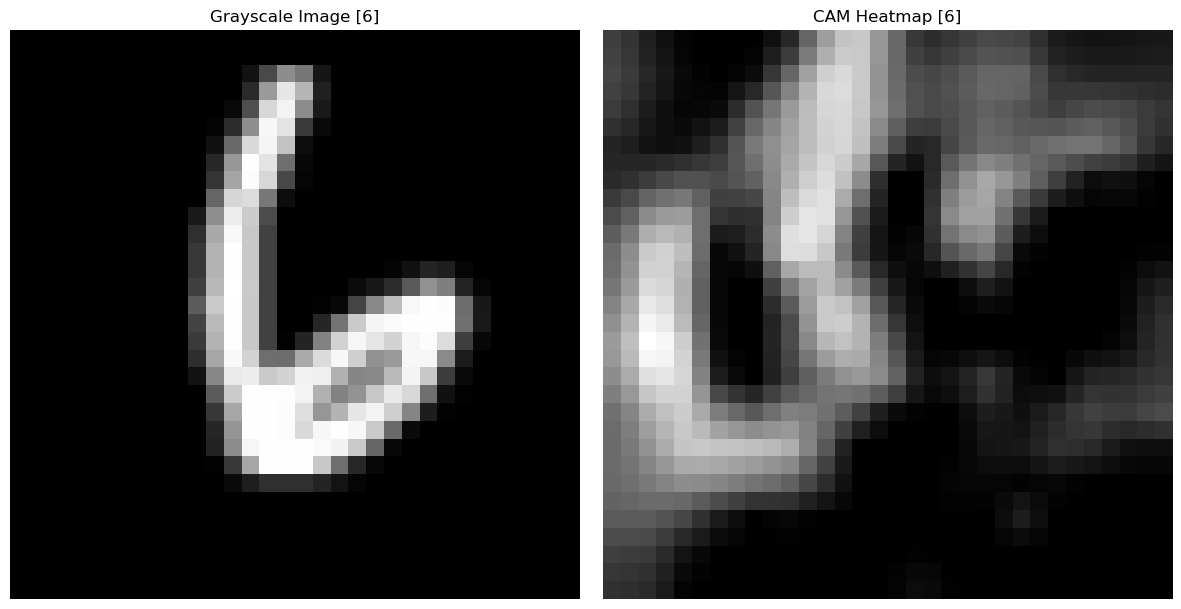

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the grayscale image in the first subplot
axes[0].imshow(digit_image_normalized, cmap="gray")
axes[0].set_title(f"Grayscale Image {labels.numpy()}")
axes[0].axis("off")  # Optional: Turn off axes

# Plot the CAM heatmap in the second subplot
axes[1].imshow(grayscale_cam[0, :, :], cmap="gray")
axes[1].set_title(f"CAM Heatmap {labels.numpy()}")
axes[1].axis("off")  # Optional: Turn off axes

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()

### Cascading randomness 